HMM Personal Project

This project aims to use the Hidden Markov Model to identify different regimes in a Time Series.
The HMM model will be done from scratch, and the results will be validated using external libraries.
An effort is made to use as little external libraries as possible.

Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Synthetic parameters used to create the time series

In [3]:
#Number of States
N = 3

#Number of observations
T = 400

#initial probability distribution, three state markov chain
pi = [0.3,0.5,0.2]

#transition probability matrix
A= [[0.9,0.05,0.05],[0.1,0.7,0.2],[0.05,0.05,0.9]]

#set seed
np.random.seed(1342)

Lets assume we are looking at coin tosses, and three coins are available.

State 1: Coin 1: tail biased, 0,7 tails, 0.3 heads\
State 2: Coin 2: Fair Coin: 0.5, tails, 0.5 heads\
State 3: Coin 3: head biased, 0.2 tails, 0.8 heads


Say we gain 1$ when we hit heads, and loose 1$ with tails, we can create a realization of this multi-state random walk

In [4]:
#coin variables
dbias_tails = 0.7
fbias_tails = 0.5
ubias_tails = 0.2

#Probability distribution of the observations at each state (Emission matrix)
E = np.matrix([[dbias_tails, 1-dbias_tails],[fbias_tails, 1-fbias_tails],[ubias_tails, 1-ubias_tails]])

In [5]:
#set the initial state
rand = np.random.uniform()
lhs = 0

#Use the random uniform variable and the distribution to find which state we are starting in
for i in pi:
    if rand <= i + lhs:
        state = pi.index(i)
        break
    lhs += i

#States array
states = [state]

#Realization array
realization = []
running = 0
observations = []

for iteration in range(T):
    #we know which state we start in (which coin we have), we flip the coin
    u = np.random.uniform()
    match state:
        case 0:
            if u < dbias_tails:
                running = running - 1
                realization.append(running)
                observations.append(0)
            else:
                running = running + 1
                realization.append(running)
                observations.append(1)
        case 1:
            if u < fbias_tails:
                running = running - 1
                realization.append(running)
                observations.append(0)
            else:
                running = running + 1
                realization.append(running)
                observations.append(1)
        case 2:
            if u < ubias_tails:
                running = running - 1
                realization.append(running)
                observations.append(0)
            else:
                running = running + 1
                realization.append(running)
                observations.append(1)
    
    #Once the flip is done and the score is updated, we may or may not change states
    u2 = np.random.uniform()
    distr = A[state]
    lhs = 0
    for j in distr:
        if u2 <= j + lhs:
            state = distr.index(j)
            break
        lhs += j
    states.append(state)


Plot realization and states

3


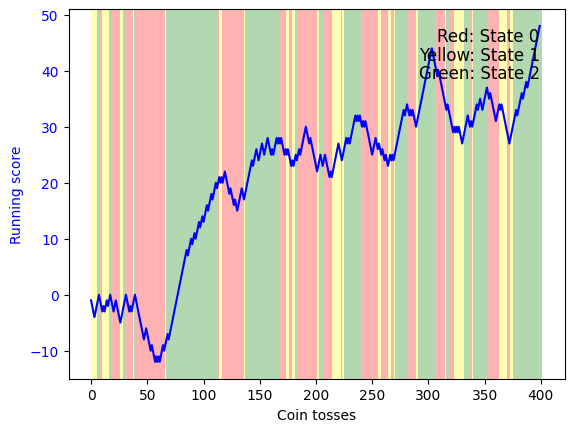

In [6]:
fig, ax1 = plt.subplots()
print(N)

ax1.plot(realization, color='blue', label='Realization')
ax1.set_xlabel('Coin tosses')
ax1.set_ylabel('Running score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

for i in range(len(states)):
    if states[i] == 0:
        ax1.axvspan(i, i+1, facecolor='red', alpha=0.3)
    elif states[i] == 1:
        ax1.axvspan(i, i+1, facecolor='yellow', alpha=0.3)
    elif states[i] == 2:
        ax1.axvspan(i, i+1, facecolor='green', alpha=0.3)

ax1.text(0.95, 0.95, 'Red: State 0', transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
ax1.text(0.95, 0.90, 'Yellow: State 1', transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
ax1.text(0.95, 0.85, 'Green: State 2', transform=ax1.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')

plt.show()


Now that we have our realization, we will try to find the states and the parameters using the HMM model\

In practice this would be as if we observed someone play the coin-flip game for 1000 flips and are now trying to infer the model from these observations. We do not know the state sequence or the transition probabilities.

To do so, we use the forward-backward algorithm, or Baum-Welch algorithm, which is an EM algorithm.\
For this, we need an initial estimate of the A matrix and emission probabilites.

The forward algorithm: It allows to find the probability of being in state j after seeing the first to observations, given the HMM parameters

#### Initialization:

$$
\alpha_{1}(j)=\pi_{j} b_{j}\left(o_{1}\right) \quad 1 \leq j \leq N
$$

#### Recursion

$$
\alpha_{t}(j)=\sum_{i=1}^{N} \alpha_{t-1}(i) a_{i j} b_{j}\left(o_{t}\right) ; \quad 1 \leq j \leq N, 1<t \leq T
$$

#### Termination

$$
P(O \mid \lambda)=\sum_{i=1}^{N} \alpha_{T}(i)
$$

In [7]:
#this is our probability matrix
forward = np.zeros((N, T))

for i in range(N):
    forward[i,0] =  pi[i]*E[i,observations[0]]

for t in range(1,T):
    for n in range(N):
        #np.ones for the sum, forward[]*A[][] multiplies each state by the transition probability to state n, and E[]
        #gives the probability of seeing observation t when in state n
        forward[n,t] = np.ones(3).T@(forward[:,t-1]*A[:][n]*E[n,observations[t]])

forwardprob = np.ones(3)@forward[:,T-1]
print(forwardprob)


9.094001125790341e-116


Now we need to do the backward algorithm: The backward probability $\beta$ is the probability of seeing the observations from time $t+1$ to the end, given that we are in state $i$ at time $t$ (and given the automaton $\lambda$ ) [1]:

$$
\begin{equation*}
\beta_{t}(i)=P\left(o_{t+1}, o_{t+2} \ldots o_{T} \mid q_{t}=i, \lambda\right)
\end{equation*}
$$

#### Initialization

$$
\beta_{T}(i) = 1, \quad 1 \leq i \leq N
$$

#### Recursion

$$
\beta_{t}(i) = \sum_{j=1}^{N} a_{i j} b_{j}\left(o_{t+1}\right) \beta_{t+1}(j), \quad 1 \leq i \leq N, \; 1 \leq t < T
$$

#### Termination

$$
P(O \mid \lambda) = \sum_{j=1}^{N} \pi_{j} b_{j}\left(o_{1}\right) \beta_{1}(j)
$$

In [8]:
#this is our probability matrix
backward = np.zeros((N, T))

for i in range(N):
    backward[i,T-1] =  1

for t in reversed(range(0,T-1)):
    for n in range(N):
        #np.ones for the sum, backward[]*A[][] multiplies each state by the transition probability to state n, and E[]
        #gives the probability of seeing observation t+1 when in state n
        backward[n,t] = np.ones(3).T@(backward[:,t+1]*A[n][:]*E[n,observations[t+1]])

backwardprob = np.ones(3)@(pi*E[:,observations[0]]*backward[:,0]).T
print(backwardprob[0,0])

3.244548418241865e-115


In [9]:
test = 0
